# Data Loading

In [1]:
import os

import numpy as np
import pandas as pd
import polars as pl

In [2]:
cwd = os.getcwd()
cwd, _ = os.path.split(cwd)
cwd

'/Users/fynn/Uni/MA'

In [3]:
BATCH_SIZE = 50_000

In [4]:
import tensorflow as tf
from tensorflow import keras

samples = os.path.join(cwd, "data", "2D", "MIP")
class_names = ["solved", "interrupted"]

train_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = samples,
    labels = "inferred",
    label_mode = "binary",
    class_names = class_names,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = False, # Shuffle Buffer takes much time
    seed = 3093453,
    validation_split = 0.2,
    subset = "training",
    follow_links = False
)

val_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = samples,
    labels = "inferred",
    label_mode = "binary",
    class_names = class_names,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = False, # Shuffle Buffer takes much time
    seed = 3093453,
    validation_split = 0.2,
    subset = "validation",
    follow_links = False
)

class_names = np.array(["solved", "interrupted"])

Found 710800 files belonging to 2 classes.
Using 568640 files for training.


2023-11-29 16:57:29.234044: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-29 16:57:29.234083: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-29 16:57:29.234086: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-29 16:57:29.234123: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-29 16:57:29.234140: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 710800 files belonging to 2 classes.
Using 142160 files for validation.


In [5]:
for X,y in train_dataset.take(1):
    pass

In [6]:
XX = X

In [7]:
y = pd.Series(X.numpy().astype(str)).str.extractall("MIP Improvement( )")
y = y.groupby(y.index.get_level_values(0)).count().to_numpy()[:,0]
y = y == 1

In [8]:
print(X.numpy().astype(str)[0])

dataset: C
instance: BY
+-----------+
2D Packing MIP with Time Limit 3.1828198096035143 [s] in Truck P097060901
Stack 0 with items: ['0090016900_27022023019535', '0090016900_27022023019535']
Stack 1 with items: ['0090016900_27022023019535', '0090016900_27022023019535']
Stack 2 with items: ['0090016900_27022023019535', '0090016900_27022023019535']
Stack 3 with items: ['0090016900_27022023019535', '0090016900_27022023014320']
Stack 4 with items: ['0090016900_27022023014320', '0090016900_27022023014320']
Stack 5 with items: ['0090016900_27022023014320', '0090016900_27022023014320']
Stack 6 with items: ['0090016900_27022023014320', '0090016900_27022023010385']
Stack 7 with items: ['0090016900_27022023010385', '0090016900_27022023010385']
Stack 8 with items: ['0090016900_27022023036162']
Stack 9 with items: ['0090016900_27022023038106', '0090016900_27022023043809']
Stack 10 with items: ['0090016900_27022023043809', '0090016900_27022023043809']
MIP Improvement - 2D Vol: 30.0 [m2] - packed 2D

In [9]:
X = X.numpy().astype(str)
df = pl.DataFrame({"raw": X})
print(df[0, 0])

dataset: C
instance: BY
+-----------+
2D Packing MIP with Time Limit 3.1828198096035143 [s] in Truck P097060901
Stack 0 with items: ['0090016900_27022023019535', '0090016900_27022023019535']
Stack 1 with items: ['0090016900_27022023019535', '0090016900_27022023019535']
Stack 2 with items: ['0090016900_27022023019535', '0090016900_27022023019535']
Stack 3 with items: ['0090016900_27022023019535', '0090016900_27022023014320']
Stack 4 with items: ['0090016900_27022023014320', '0090016900_27022023014320']
Stack 5 with items: ['0090016900_27022023014320', '0090016900_27022023014320']
Stack 6 with items: ['0090016900_27022023014320', '0090016900_27022023010385']
Stack 7 with items: ['0090016900_27022023010385', '0090016900_27022023010385']
Stack 8 with items: ['0090016900_27022023036162']
Stack 9 with items: ['0090016900_27022023038106', '0090016900_27022023043809']
Stack 10 with items: ['0090016900_27022023043809', '0090016900_27022023043809']
MIP Improvement - 2D Vol: 30.0 [m2] - packed 2D

# Processing functions:

## Extract raw data

In [10]:
def extract_raw_data(df: pl.DataFrame) -> pl.DataFrame:
    """
    Extracts features via regex from raw txt-file input.
    Drops rows which dont contain a truck_id or 3D packing instances
    """
    df = df.with_columns([
        pl.Series(name="index", values=np.arange(len(df.collect()))),
        #pl.Series(name="index", values=np.arange(len(df))),
        pl.col("raw").str.extract("in Truck (\w\d{9})\n").alias("truck_id"),
        pl.col("raw").str.extract("dataset: (\w*)\n").alias("dataset"),
        pl.col("raw").str.extract("instance: ([A-Z0-9]*)\n").alias("instance"),
    ])
    
    return df


In [11]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .collect()
    .head()
)

raw,index,truck_id,dataset,instance
str,i64,str,str,str
"""dataset: C ins…",0,"""P097060901""","""C""","""BY"""
"""dataset: X ins…",1,"""P171423101""","""X""","""TR6"""
"""dataset: X ins…",2,"""P214420403""","""X""","""TR4"""
"""dataset: C ins…",3,"""P083513403""","""C""","""VA"""
"""dataset: X ins…",4,"""P193056321""","""X""","""SA"""


## Explode instance into stacks:

In [12]:
def explode_instances_into_stacks(df: pl.LazyFrame) -> pl.DataFrame:
    """
    Use regex to extract all stacks made of item ids, and explode df
    into rows of stacks, belonging to an instance.
    """
    
    df = (
        df.with_columns([
            pl.col("raw").str.extract_all("Stack \d* with items: (\[.*\])\n").alias("stacks")
        ])
          .drop(["raw"])
          .explode(columns = ["stacks"])\
          .with_columns([
              pl.col("stacks").str.extract("Stack (\d*) with").cast(pl.Int64, strict=False).alias("stack_id"),
              pl.col("stacks").str.extract_all("(\d{10}_\d{14})").alias("item_id")
          ])
    )
    return df


In [13]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .collect()
    .head()
)

index,truck_id,dataset,instance,stacks,stack_id,item_id
i64,str,str,str,str,i64,list[str]
0,"""P097060901""","""C""","""BY""","""Stack 0 with i…",0,"[""0090016900_27022023019535"", ""0090016900_27022023019535""]"
0,"""P097060901""","""C""","""BY""","""Stack 1 with i…",1,"[""0090016900_27022023019535"", ""0090016900_27022023019535""]"
0,"""P097060901""","""C""","""BY""","""Stack 2 with i…",2,"[""0090016900_27022023019535"", ""0090016900_27022023019535""]"
0,"""P097060901""","""C""","""BY""","""Stack 3 with i…",3,"[""0090016900_27022023019535"", ""0090016900_27022023014320""]"
0,"""P097060901""","""C""","""BY""","""Stack 4 with i…",4,"[""0090016900_27022023014320"", ""0090016900_27022023014320""]"


## Explode stacks into items:

In [14]:
def explode_stacks_into_items(df: pl.DataFrame) -> pl.DataFrame:
    """
    Use regex to identify a stack and explode it into items,
    belonging to a stack, which again belongs to an instance.
    """
    df = df.with_columns([
        pl.col("stacks").str.extract("Stack (\d*) with").cast(pl.Int64, strict=False).alias("stack_id"),
        pl.col("stacks").str.extract_all("(\d{10}_\d{14})").alias("item_id")
    ]).drop("stacks").explode("item_id")\
    
    return df

In [15]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .collect()
    #.head()
)

index,truck_id,dataset,instance,stack_id,item_id
i64,str,str,str,i64,str
0,"""P097060901""","""C""","""BY""",0,"""0090016900_270…"
0,"""P097060901""","""C""","""BY""",0,"""0090016900_270…"
0,"""P097060901""","""C""","""BY""",1,"""0090016900_270…"
0,"""P097060901""","""C""","""BY""",1,"""0090016900_270…"
0,"""P097060901""","""C""","""BY""",2,"""0090016900_270…"
0,"""P097060901""","""C""","""BY""",2,"""0090016900_270…"
0,"""P097060901""","""C""","""BY""",3,"""0090016900_270…"
0,"""P097060901""","""C""","""BY""",3,"""0090016900_270…"
0,"""P097060901""","""C""","""BY""",4,"""0090016900_270…"


## Load and Merge Items

In [16]:
folder = "truck-item-infos"
file = "items.csv"

item_path = os.path.join(cwd, folder, file)
items = pl.read_csv(source = item_path);

items = items.lazy().with_columns([
    (pl.col("Item ident").alias("item_id")),
    (pl.col("Length") / 1000), # mm to m
    (pl.col("Width") / 1000),  # mm to m
    (pl.col("Height") / 1000), # mm to m
    (pl.col("Nesting height") / 1000), # mm to m
    (pl.col("Weight") / 1000), # kg to tons
    (pl.col("Forced orientation") == "lengthwise").alias("ForcedLength"),
    (pl.col("Forced orientation") == "widthwise").alias("ForcedWidth"),
    ((pl.col("Height") - pl.col("Nesting height")) / 1000).alias("NestedHeight"),
    pl.col("dataset").str.extract("([A-Z])")
]).drop([
    "Forced orientation", "Max stackability", "Inventory cost",
    "Earliest arrival time", "Latest arrival time", "Number of items",
    "instance_id",
    "Stackability code",
    "Item ident" # drop because of rename earlier
]).unique()

items.collect().head()

Supplier code,Supplier dock,Plant code,Plant dock,Product code,Package code,Length,Width,Height,Weight,Nesting height,dataset,instance,item_id,ForcedLength,ForcedWidth,NestedHeight
i64,str,i64,str,str,str,f64,f64,f64,f64,f64,str,str,str,bool,bool,f64
11740101,null,90016900,"""169GD-60""","""140461084R""","""SLI---0770""",1.2,1.0,0.975,0.172384,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.93
2695000,null,90016900,"""GRF1""","""272702687R""","""ECM---6655""",2.4,1.2,0.76,0.2542,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.715
27029901,null,90016900,"""169GD-60""","""769150010R""","""SFDA--6608""",1.6,1.2,0.93,0.17098,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.885
21798202,null,90016900,"""GRD1""","""144605995R""","""SLI---0770""",1.2,1.0,0.975,0.181,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.93
24099001,null,90016900,"""169GB-30""","""791A20004R""","""CON-S-0130""",0.78,0.57,0.478,0.0819,0.047,"""C""","""BY""","""0090016900_270…",false,true,0.431


In [17]:
def join_items(df: pl.DataFrame, items) -> pl.DataFrame:
    """
    Perform a simple left join to add item level info.
    
    Validation sadly not supported for multiple keys (yet?)
    """
    
    return df.join(items, how = "left", on = ["dataset", "instance", "item_id"])

In [18]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .collect()
    .head()
)

index,truck_id,dataset,instance,stack_id,item_id,Supplier code,Supplier dock,Plant code,Plant dock,Product code,Package code,Length,Width,Height,Weight,Nesting height,ForcedLength,ForcedWidth,NestedHeight
i64,str,str,str,i64,str,i64,str,i64,str,str,str,f64,f64,f64,f64,f64,bool,bool,f64
0,"""P097060901""","""C""","""BY""",0,"""0090016900_270…",24979000,null,90016900,"""169GB-20""","""631007236R""","""MTEM--7892""",2.0,1.2,1.22,0.210962,0.045,false,false,1.175
0,"""P097060901""","""C""","""BY""",0,"""0090016900_270…",24979000,null,90016900,"""169GB-20""","""631007236R""","""MTEM--7892""",2.0,1.2,1.22,0.210962,0.045,false,false,1.175
0,"""P097060901""","""C""","""BY""",1,"""0090016900_270…",24979000,null,90016900,"""169GB-20""","""631007236R""","""MTEM--7892""",2.0,1.2,1.22,0.210962,0.045,false,false,1.175
0,"""P097060901""","""C""","""BY""",1,"""0090016900_270…",24979000,null,90016900,"""169GB-20""","""631007236R""","""MTEM--7892""",2.0,1.2,1.22,0.210962,0.045,false,false,1.175
0,"""P097060901""","""C""","""BY""",2,"""0090016900_270…",24979000,null,90016900,"""169GB-20""","""631007236R""","""MTEM--7892""",2.0,1.2,1.22,0.210962,0.045,false,false,1.175


## Group by stack ID:

In [19]:
def group_items_by_stack(df: pl.DataFrame) -> pl.DataFrame:
    """
    Group item level into back into a stack
    
    - Note that the Width and Length are the same for all items
    - Weight and Height have to be summed up, correcting for nesting height
    - forcedOrientation of a single item makes the whole stack oriented
    - Include Logistics info for stop differentation down the road
    
    """
    
    df = df.group_by(["index", "dataset", "instance", "truck_id", "stack_id"],
                    maintain_order = True)\
    .agg([
        pl.count("item_id").alias("items"),
        pl.max("Length"),
        pl.max("Width"),
        pl.sum("NestedHeight"),
        pl.last("Nesting height"),
        pl.sum("Weight"),
        pl.any("ForcedLength"),
        pl.any("ForcedWidth"),
        # Logistic order info
        pl.first("Supplier code"),
        pl.first("Supplier dock"),
        pl.first("Plant dock")
    ]).sort(["index", "stack_id"]).drop(["stack_id"])

    return df

In [20]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .collect()
    #.head()
)
# (507_770, 7)

index,dataset,instance,truck_id,items,Length,Width,NestedHeight,Nesting height,Weight,ForcedLength,ForcedWidth,Supplier code,Supplier dock,Plant dock
i64,str,str,str,u32,f64,f64,f64,f64,f64,bool,bool,i64,str,str
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,24979000,null,"""169GB-20"""
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,24979000,null,"""169GB-20"""
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,24979000,null,"""169GB-20"""
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,24979000,null,"""169GB-20"""
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,24979000,null,"""169GB-20"""
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,24979000,null,"""169GB-20"""
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,24979000,null,"""169GB-20"""
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,24979000,null,"""169GB-20"""
0,"""C""","""BY""","""P097060901""",1,2.2,1.2,1.305,0.045,0.921605,false,false,24979000,null,"""169GB-20"""


## Data Vis:

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="talk",
        style="darkgrid")

In [22]:
X = (
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .collect()
    #.head()
)
X

index,dataset,instance,truck_id,items,Length,Width,NestedHeight,Nesting height,Weight,ForcedLength,ForcedWidth,Supplier code,Supplier dock,Plant dock
i64,str,str,str,u32,f64,f64,f64,f64,f64,bool,bool,i64,str,str
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,24979000,null,"""169GB-20"""
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,24979000,null,"""169GB-20"""
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,24979000,null,"""169GB-20"""
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,24979000,null,"""169GB-20"""
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,24979000,null,"""169GB-20"""
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,24979000,null,"""169GB-20"""
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,24979000,null,"""169GB-20"""
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,24979000,null,"""169GB-20"""
0,"""C""","""BY""","""P097060901""",1,2.2,1.2,1.305,0.045,0.921605,false,false,24979000,null,"""169GB-20"""


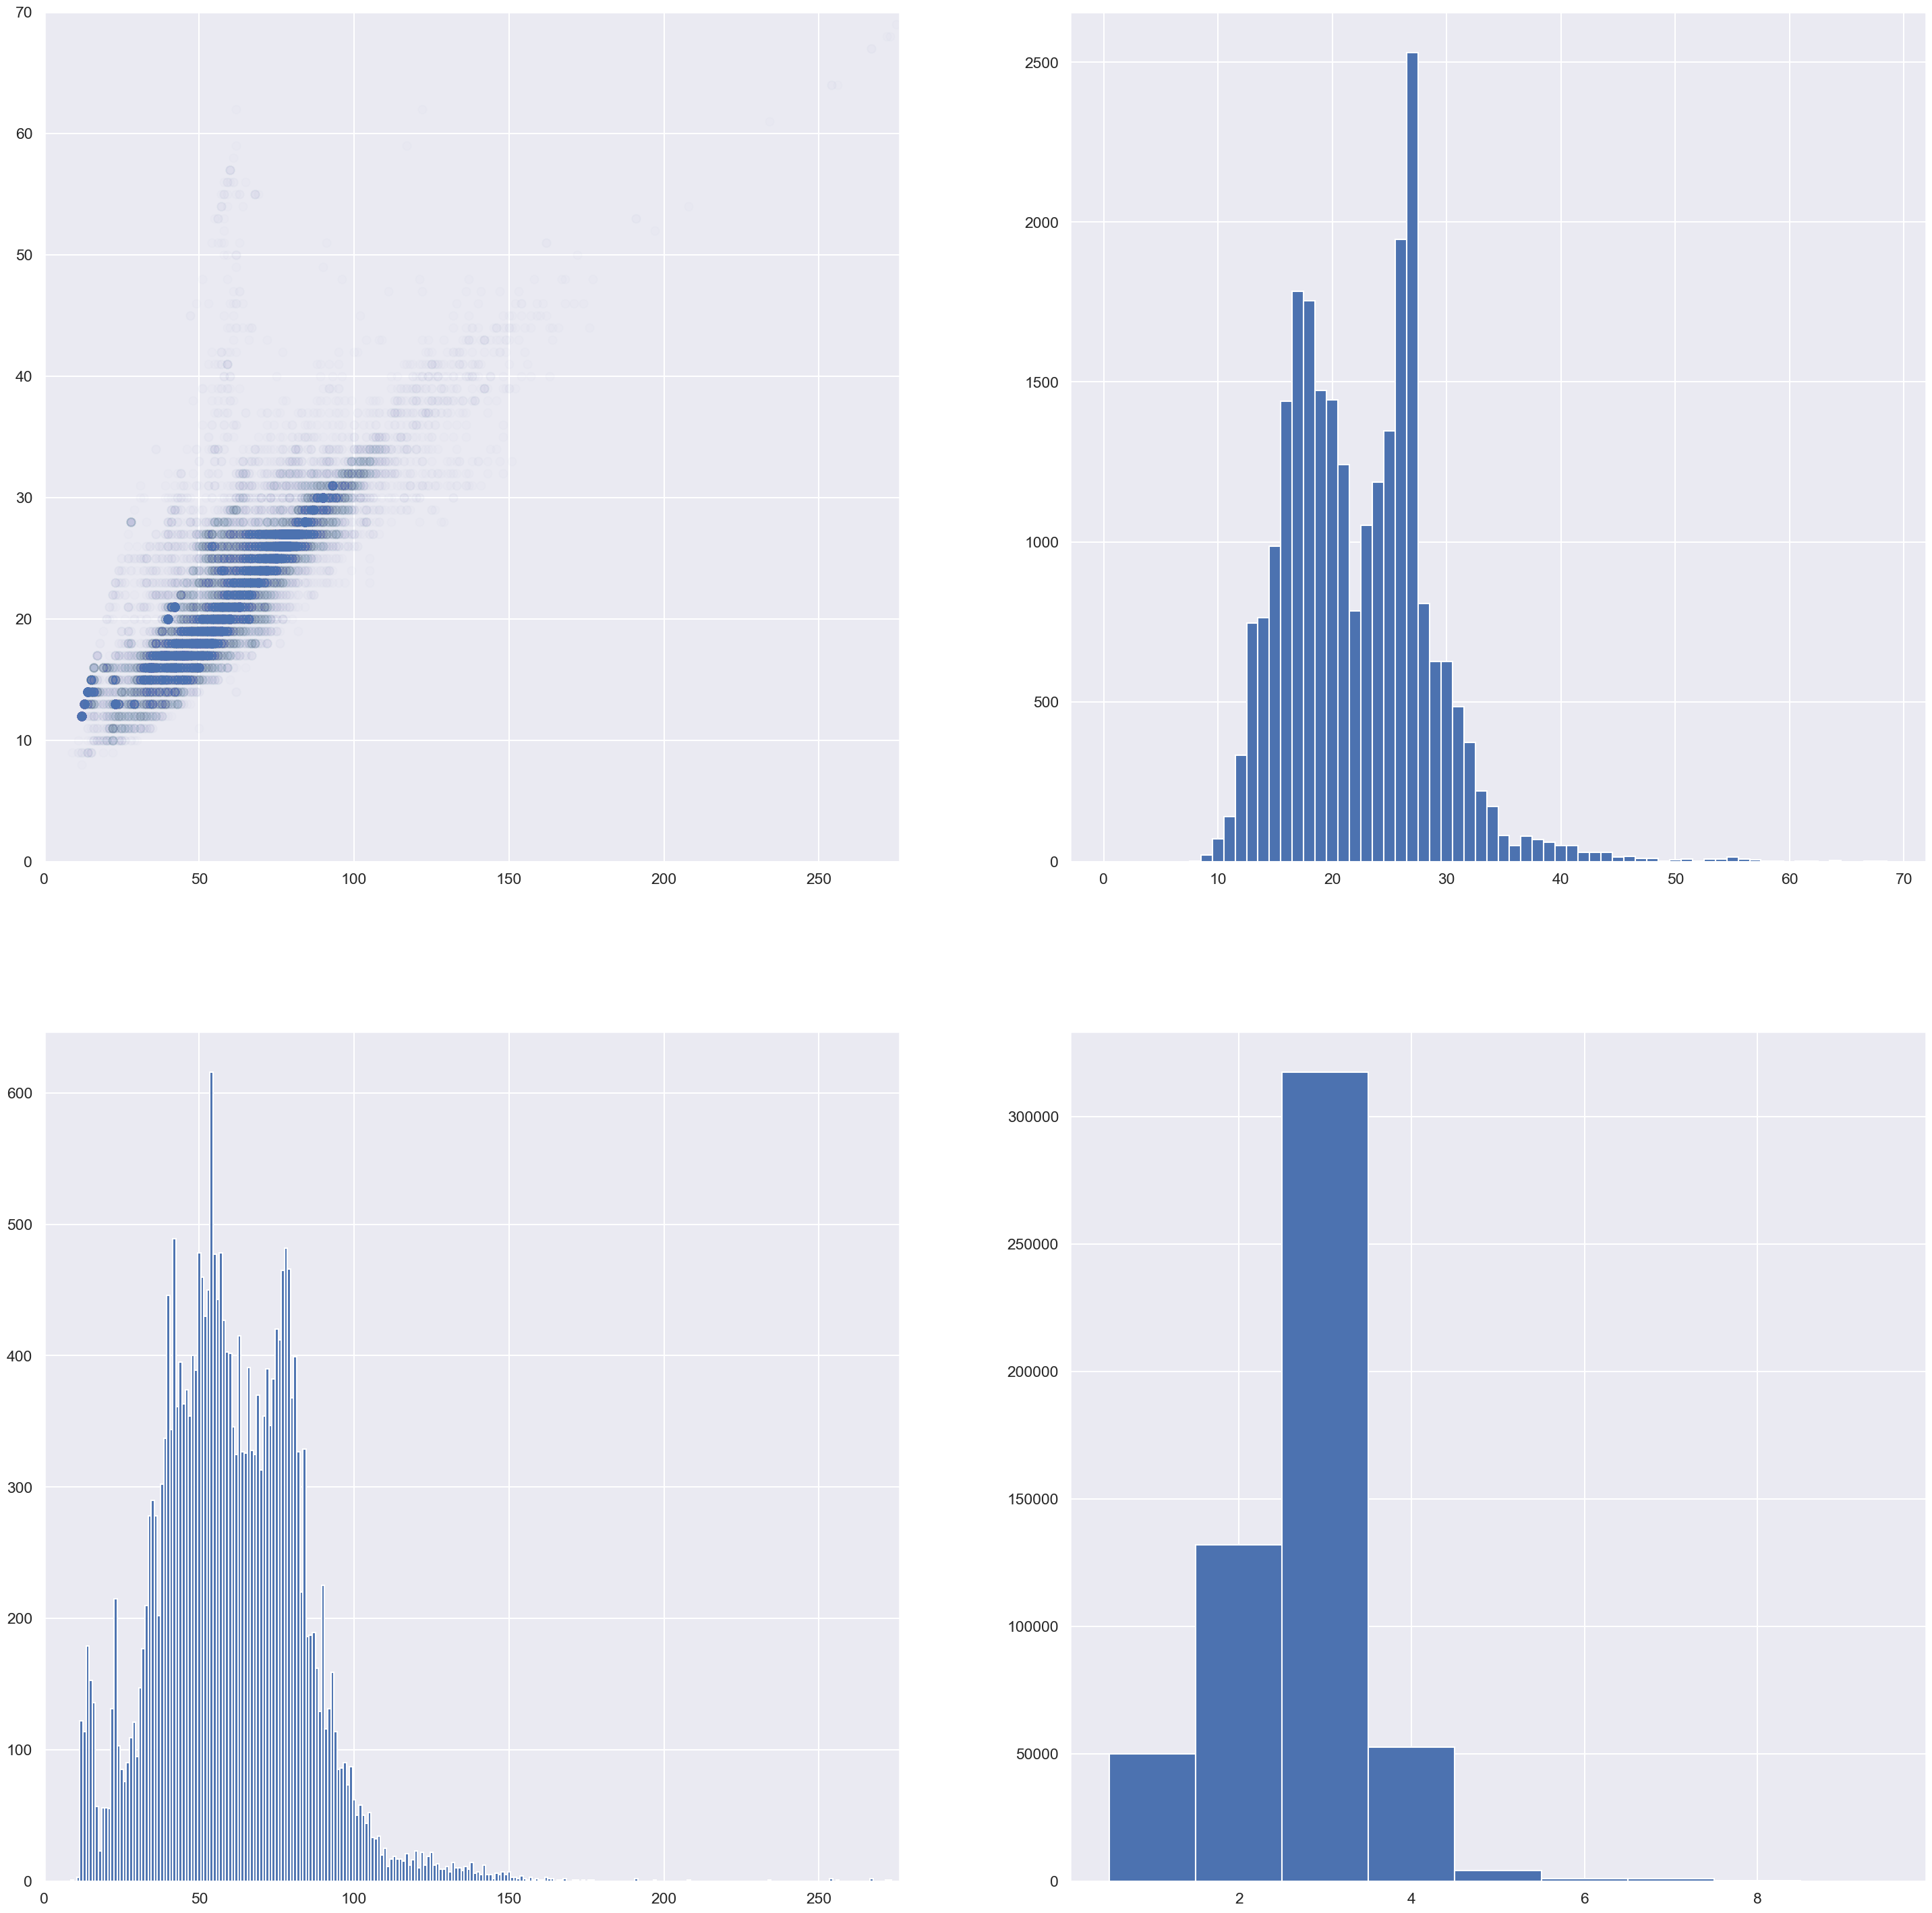

In [23]:
x = X.group_by("index").agg(
    pl.col("items").sum().alias("total_items"),
    pl.col("items").count().alias("total_stacks")
)

item_max = x.max()[0, "total_items"]
stack_max = x.max()[0, "total_stacks"]

fig, ax = plt.subplots(nrows=2, ncols=2,figsize = (36, 36))



ax[0, 0].scatter(
    y=x["total_stacks"],
    x=x["total_items"],
    #c = y.numpy(),
    alpha = 0.01
);
ax[0, 0].set(xlim=[0, item_max+1])
ax[0, 0].set(ylim=[0, stack_max+1])

ax[0, 1].hist(x["total_stacks"], bins=np.arange(0, stack_max, 1)+0.5)

ax[1, 0].hist(x["total_items"], bins=np.arange(0, item_max, 1)+0.5)
ax[1, 0].set(xlim=[0, item_max+1])



x = X["items"].to_numpy()
ax[1, 1].hist(x, bins=np.arange(0, 10, 1)+0.5);


In [24]:
import plotly.express as px

# https://stackoverflow.com/questions/52771328/plotly-chart-not-showing-in-jupyter-notebook
import plotly.io as pio
pio.renderers.default = 'iframe'

x = X.group_by("index").agg(
    pl.col("items").sum().alias("total_items"),
    pl.col("items").count().alias("total_stacks")
)

px.scatter(
    x,
    y="total_stacks",
    x="total_items",
    opacity = 0.1
)

## Merge Loading order

In [25]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Supplier code", "Supplier dock", "Plant dock",
              "Supplier loading order", "Supplier dock loading order", "Plant dock loading order",
             ]

truck_stops = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .unique()
    .rename({"Id truck": "truck_id"})
    .sort(["dataset", "instance", "truck_id"])
    .with_columns([pl.col("dataset").str.extract("(\w)")])
)
truck_stops.collect().head()

Supplier code,Supplier loading order,Supplier dock,Supplier dock loading order,Plant dock,Plant dock loading order,truck_id,dataset,instance
i64,i64,str,i64,str,i64,str,str,str
62059600,1,null,1,"""X0""",1,"""P187721701""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730401""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730403""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730405""","""A""","""AS"""
29908700,1,null,1,"""X4""",1,"""P187730407""","""A""","""AS"""


In [26]:
def join_truck_loading_order(df: pl.DataFrame, truck_stops) -> pl.DataFrame:
    """
    Extract the loading orders in the truck_stops
    from the supplier and plant order, given by the stacks/items
    
    TODO:
    -----
    
    - Include a check whether the last item in a stack is different from the first
        This would mean that it is a multistack, making the problem much more difficult
        Jakob said this is often explicitly forbidden by the heuristic, and rarely the 
        case anyways.
    """
    
    truck_join_clms = ["truck_id", "dataset", "instance",
                       "Supplier code", "Supplier dock", "Plant dock"]
    truck_info_clms = ["Supplier loading order",
                       "Supplier dock loading order",
                       "Plant dock loading order"]
    
    df = df.join(truck_stops, how = "left", on = truck_join_clms )
    
    df = df.with_columns([
        pl.concat_str(pl.col(truck_info_clms), separator = "-").alias("packing_order")
    ])
    
    df = df.drop(truck_join_clms[-3:]
                 + truck_info_clms
    )
    
    return df
    

In [27]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .pipe(join_truck_loading_order, truck_stops)
    .collect()
    #.head()
)

index,dataset,instance,truck_id,items,Length,Width,NestedHeight,Nesting height,Weight,ForcedLength,ForcedWidth,packing_order
i64,str,str,str,u32,f64,f64,f64,f64,f64,bool,bool,str
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,"""1-1-1"""
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,"""1-1-1"""
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,"""1-1-1"""
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,"""1-1-1"""
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,"""1-1-1"""
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,"""1-1-1"""
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,"""1-1-1"""
0,"""C""","""BY""","""P097060901""",2,2.0,1.2,2.35,0.045,0.421924,false,false,"""1-1-1"""
0,"""C""","""BY""","""P097060901""",1,2.2,1.2,1.305,0.045,0.921605,false,false,"""1-1-1"""


# Tabular Data for ML

## load and Join truck info

In [28]:
file = "trucks.csv"

truck_path = os.path.join(cwd, folder, file)

truck_clms = ["Id truck", "dataset", "instance",
              "Width", "Length", "Max weight"
             ]

new_clm_names = {"Width": "TruckWidth",
                 "Length": "TruckLength",
                 "Max weight": "TruckWeight"}

truck_dims = (
    pl.read_csv(source = truck_path, columns = truck_clms)
    .lazy()
    .rename({"Id truck": "truck_id"})
    .rename(new_clm_names)
    .unique()
    .sort(["dataset", "instance", "truck_id"])
)

truck_dims = truck_dims.with_columns([
    (pl.col("TruckLength") / 1000),
    (pl.col("TruckWidth") / 1000),
    (pl.col("TruckWeight") / 1000),
    (pl.col("dataset").str.extract("([A-Z])")),
])

truck_dims.collect()

truck_id,TruckLength,TruckWidth,TruckWeight,dataset,instance
str,f64,f64,f64,str,str
"""P187721701""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730401""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730403""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730405""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730407""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730501""",14.94,2.5,24.0,"""A""","""AS"""
"""P187730503""",14.94,2.5,24.0,"""A""","""AS"""
"""P187731001""",14.94,2.5,24.0,"""A""","""AS"""
"""P187731005""",14.94,2.5,24.0,"""A""","""AS"""


In [29]:
def normalize_stacks_by_truck(df: pl.DataFrame, truck_dims: pl.LazyFrame) -> pl.DataFrame:
    """
    Update the 'ForcedLength' column to include implicit cases.
    
    Calculated Length and Width Remainders
    
    Explicit cases are those where the Orienteation is directly forced.
    Implicit cases are those where the length is greater than the truck width,
    forcing the orientaiton to be lengthwise.
    
    Requires Truck info
    """
    
    df = df.join(truck_dims, how = "left", on = ["truck_id", "dataset", "instance"])
    
    df = df.with_columns([
        # Inplicitly forced by Length
        #(pl.col("ForcedLength") | pl.col("Length") > pl.col("TruckWidth")).alias("ForcedLength"),
        (pl.col("TruckWidth") % pl.col("Length")).alias("LengthRemainder"),
        (pl.col("TruckWidth") % pl.col("Width")).alias("WidthRemainder"),
    ])
    
    
    # relevant columns
    clms = df.head().collect().columns
    truck_clms = [clm for clm in truck_dims.columns if clm[0].isupper()]
    
    # divide stack dimension by corresponding truck dimension
    df = df.with_columns([
        (pl.col(clm) / pl.col(truck_clm))
        for clm in clms 
        for truck_clm in truck_clms  
        if (clm in truck_clm) and (clm != truck_clm)
        #and ("Forced" not in clm)
    ])
    
    # Length Remainder has been divided by the Truck Length, but must be divided by the truck width!
    df = df.with_columns([
        (pl.col("LengthRemainder") * pl.col("Length") / pl.col("Width")).alias("LengthRemainder")
    ])

    # calculate Area as proportion of Truck:
    df = df.with_columns([
        (pl.col("Length") * pl.col("Width")).alias("Area")
    ])
    
    df = df.drop(truck_clms)

    return df


In [30]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .pipe(join_truck_loading_order, truck_stops)
    # Here we start to gain tabular data:
    .pipe(normalize_stacks_by_truck, truck_dims)
    .collect()
    #.head()
)

index,dataset,instance,truck_id,items,Length,Width,NestedHeight,Nesting height,Weight,ForcedLength,ForcedWidth,packing_order,LengthRemainder,WidthRemainder,Area
i64,str,str,str,u32,f64,f64,f64,f64,f64,bool,bool,str,f64,f64,f64
0,"""C""","""BY""","""P097060901""",2,0.148148,0.491803,2.35,0.045,0.016877,false,false,"""1-1-1""",0.132543,0.04,0.07286
0,"""C""","""BY""","""P097060901""",2,0.148148,0.491803,2.35,0.045,0.016877,false,false,"""1-1-1""",0.132543,0.04,0.07286
0,"""C""","""BY""","""P097060901""",2,0.148148,0.491803,2.35,0.045,0.016877,false,false,"""1-1-1""",0.132543,0.04,0.07286
0,"""C""","""BY""","""P097060901""",2,0.148148,0.491803,2.35,0.045,0.016877,false,false,"""1-1-1""",0.132543,0.04,0.07286
0,"""C""","""BY""","""P097060901""",2,0.148148,0.491803,2.35,0.045,0.016877,false,false,"""1-1-1""",0.132543,0.04,0.07286
0,"""C""","""BY""","""P097060901""",2,0.148148,0.491803,2.35,0.045,0.016877,false,false,"""1-1-1""",0.132543,0.04,0.07286
0,"""C""","""BY""","""P097060901""",2,0.148148,0.491803,2.35,0.045,0.016877,false,false,"""1-1-1""",0.132543,0.04,0.07286
0,"""C""","""BY""","""P097060901""",2,0.148148,0.491803,2.35,0.045,0.016877,false,false,"""1-1-1""",0.132543,0.04,0.07286
0,"""C""","""BY""","""P097060901""",1,0.162963,0.491803,1.305,0.045,0.0368642,false,false,"""1-1-1""",0.079526,0.04,0.080146


### Visualization of normalized stack info:

In [31]:
def select_numeric_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    """
    Filter Function to only select numeric columns
    """

    NUMERIC_POLARS_DTYPES = [
        pl.Int8, pl.Int16, pl.Int32, pl.Int64, 
        pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
        pl.Float32, pl.Float64,
        pl.Boolean
    ]
    
    df = df.select([
        pl.col(NUMERIC_POLARS_DTYPES).cast(pl.Float64)
    ])
    
    return df


In [32]:
corr = (
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .pipe(join_truck_loading_order, truck_stops)
    # Here we start to gain tabular data:
    .pipe(normalize_stacks_by_truck, truck_dims)
    .pipe(select_numeric_dtypes)
    .collect()
    .corr()
    #.head()
)

px.imshow(corr, y = corr.columns, aspect="auto")

## Aggregate Stacks by Instance

In [33]:
def group_stacks_by_instance(df: pl.DataFrame, sort = False) -> pl.DataFrame:
    """
    Aggregate stack info back into features of a single instance.
    """
    
    # could be extended for more features, eg pl.median and "Density"
    agg_funcs = [
        #pl.min,
        pl.mean,
        pl.max,
        pl.var, 
        #pl.n_unique
    ]
    clms = ["Length", "Width", "Area", "Weight", "LengthRemainder", "WidthRemainder"]
    

    df = df.group_by(["dataset", "instance", "truck_id", "index"])\
    .agg([
        pl.col("index").count().alias("stacks"),
        pl.sum("items"),
        pl.sum("Area").alias("TotalArea"),
        pl.sum("Weight").alias("TotalWeight"),
        #pl.max("items").alias("max_stack_items"),
        #pl.std("items").alias("std_stack_items"),
        pl.mean("ForcedLength"),
        pl.mean("ForcedWidth"),
        pl.n_unique("packing_order").alias("stops"),
        # Truck Features:
        #pl.mean("TruckLength"),
        #pl.mean("TruckWidth"),
        #pl.mean("TruckWeight"),
    ]+[
        func(clm).alias("_".join([clm, func.__name__]))
        for func in agg_funcs 
        for clm in clms
    ]).drop(["Weight_mean", "Area_mean"])
    
    if sort:
        df = df.sort(["index"])
    
    return df
    

In [34]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .pipe(join_truck_loading_order, truck_stops)
    # Here we start to gain tabular data:
    .pipe(normalize_stacks_by_truck, truck_dims)
    .pipe(group_stacks_by_instance)
    .collect()
    #.head()
)

dataset,instance,truck_id,index,stacks,items,TotalArea,TotalWeight,ForcedLength,ForcedWidth,stops,Length_mean,Width_mean,LengthRemainder_mean,WidthRemainder_mean,Length_max,Width_max,Area_max,Weight_max,LengthRemainder_max,WidthRemainder_max,Length_var,Width_var,Area_var,Weight_var,LengthRemainder_var,WidthRemainder_var
str,str,str,i64,u32,u32,f64,f64,f64,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""C""","""SA2""","""P111056201""",15,27,79,0.984703,0.372478,0.0,0.0,1,0.088922,0.41014,0.008481,0.438519,0.089333,0.413934,0.036978,0.015509,0.008676,0.44,1.4069e-8,0.000001,2.1410e-8,0.000004,4.9368e-7,0.000028
"""X""","""RM4""","""P192395311""",18,23,74,0.984155,0.417012,0.0,0.0,1,0.097926,0.431397,0.067624,0.3,0.118519,0.491803,0.058288,0.029129,0.20243,0.44,0.000194,0.001958,0.000112,0.000029,0.008312,0.037709
"""X""","""TR4""","""P220425001""",30,20,55,0.970272,0.940292,0.0,0.0,1,0.114778,0.421107,0.168123,0.385,0.130741,0.430328,0.056261,0.08375,0.263159,0.44,0.000355,0.000109,0.000082,0.000431,0.009205,0.002605
"""C""","""AS3""","""P117730301""",33,29,99,0.931727,0.515064,0.0,0.0,1,0.080321,0.4,0.02008,0.5,0.080321,0.4,0.032129,0.02058,0.02008,0.5,0.0,0.0,0.0,0.000002,0.0,0.0
"""C""","""MA3""","""P104038101""",36,16,36,0.985064,0.308462,0.0,0.0,1,0.128889,0.471311,0.114951,0.14,0.142222,0.491803,0.069945,0.020855,0.150376,0.44,0.000569,0.001344,0.000225,0.000002,0.004016,0.032
"""X""","""SA""","""P177051311""",43,18,50,1.006316,0.671545,0.0,0.0,1,0.115267,0.482923,0.180744,0.083333,0.118889,0.493852,0.058714,0.057784,0.20243,0.44,0.000092,0.000707,0.00005,0.000099,0.003919,0.016847
"""X""","""BY4""","""P177064607""",48,14,33,0.998179,0.634762,0.0,0.0,1,0.144974,0.491803,0.136373,0.04,0.177778,0.491803,0.087432,0.0840288,0.173511,0.04,0.000234,0.0,0.000057,0.000219,0.002684,0.0
"""X""","""RM""","""P187390011""",57,10,19,0.990893,0.352404,0.0,0.0,1,0.155556,0.581967,0.217515,0.08,0.237037,0.983607,0.233151,0.068993,0.58801,0.44,0.002402,0.045463,0.005169,0.00042,0.042178,0.016
"""C""","""RM3""","""P081391105""",58,13,35,0.908318,0.300948,0.0,0.0,1,0.125356,0.544767,0.154544,0.295385,0.148148,0.684426,0.101396,0.027656,0.20243,0.77,0.000315,0.009889,0.000514,0.000005,0.004474,0.12031


### Visualized normalized Truck or Instance Info:

In [35]:
corr = (
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .pipe(join_truck_loading_order, truck_stops)
    # Here we start to gain tabular data:
    .pipe(normalize_stacks_by_truck, truck_dims)
    .pipe(group_stacks_by_instance)
    .pipe(select_numeric_dtypes)
    .collect()
    .corr()
    #.head()
)

px.imshow(corr, y = corr.columns, aspect="auto")

## Build an ML model to get a baseline performance

In [36]:
df = (
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .pipe(join_truck_loading_order, truck_stops)
    # Here we start to gain tabular data:
    .pipe(normalize_stacks_by_truck, truck_dims)
    .pipe(group_stacks_by_instance)
    .collect()
    .to_pandas()
    #.head()
)

del(items)
del(truck_stops)
del(truck_dims)

df

,dataset,instance,truck_id,index,stacks,items,TotalArea,TotalWeight,ForcedLength,ForcedWidth,...,Area_max,Weight_max,LengthRemainder_max,WidthRemainder_max,Length_var,Width_var,Area_var,Weight_var,LengthRemainder_var,WidthRemainder_var
0,C,VA,P083513403,3,27,70,0.963560,0.489860,0.888889,0.0,...,0.044965,0.020333,0.251721,0.44,5.636793e-05,6.163524e-03,8.315348e-05,0.000003,5.923676e-03,0.016410
1,X,BY6,P191069011,8,13,23,0.990893,0.459384,0.000000,0.0,...,0.087432,0.037439,0.132543,0.04,1.688298e-04,0.000000e+00,4.083494e-05,0.000014,2.681504e-03,0.000000
2,X,CI,P202412705,20,30,78,0.935087,0.932858,0.000000,0.2,...,0.058288,0.102987,0.202430,0.44,6.618018e-04,1.262416e-02,3.602854e-04,0.000674,7.291865e-03,0.026226
3,C,TA,P096382803,22,12,31,0.888889,0.272669,0.000000,0.0,...,0.101396,0.029796,0.202430,0.84,3.724488e-04,1.104094e-02,5.846099e-04,0.000008,4.567793e-03,0.137915
4,A,TR2,P206422101,38,30,93,0.910554,0.861116,0.000000,0.3,...,0.058288,0.105463,0.202430,0.44,2.596508e-04,7.328339e-03,1.415110e-04,0.000418,1.252017e-03,0.019559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,X,MA3,P173353901,24987,26,63,0.937158,0.975775,0.000000,0.0,...,0.036430,0.043175,0.021147,0.44,1.253561e-06,0.000000e+00,2.105552e-07,0.000024,3.948034e-05,0.000000
24996,C,MA2,P082210301,24990,21,55,0.961020,0.582750,0.000000,0.0,...,0.061020,0.065600,0.193679,0.44,3.033471e-04,1.663659e-03,1.486256e-04,0.000479,8.443909e-03,0.039619
24997,C,DO3,P086210203,24992,20,40,0.950305,0.502421,0.000000,0.0,...,0.047534,0.028279,0.230845,0.14,5.255938e-09,3.620101e-07,6.945729e-10,0.000008,6.314033e-08,0.000009
24998,C,MT3,P076574903,24993,26,76,0.951563,0.919613,0.000000,0.0,...,0.036978,0.060212,0.008676,0.44,4.376068e-08,3.721084e-06,6.659436e-08,0.000095,1.535543e-06,0.000089


In [37]:
X = XX.numpy().astype(str)
X = pl.DataFrame({"raw": X})
X

raw
str
"""dataset: C ins…"
"""dataset: X ins…"
"""dataset: X ins…"
"""dataset: C ins…"
"""dataset: X ins…"
"""dataset: X ins…"
"""dataset: X ins…"
"""dataset: C ins…"
"""dataset: X ins…"


In [38]:
print(X[0,0])

dataset: C
instance: BY
+-----------+
2D Packing MIP with Time Limit 3.1828198096035143 [s] in Truck P097060901
Stack 0 with items: ['0090016900_27022023019535', '0090016900_27022023019535']
Stack 1 with items: ['0090016900_27022023019535', '0090016900_27022023019535']
Stack 2 with items: ['0090016900_27022023019535', '0090016900_27022023019535']
Stack 3 with items: ['0090016900_27022023019535', '0090016900_27022023014320']
Stack 4 with items: ['0090016900_27022023014320', '0090016900_27022023014320']
Stack 5 with items: ['0090016900_27022023014320', '0090016900_27022023014320']
Stack 6 with items: ['0090016900_27022023014320', '0090016900_27022023010385']
Stack 7 with items: ['0090016900_27022023010385', '0090016900_27022023010385']
Stack 8 with items: ['0090016900_27022023036162']
Stack 9 with items: ['0090016900_27022023038106', '0090016900_27022023043809']
Stack 10 with items: ['0090016900_27022023043809', '0090016900_27022023043809']
MIP Improvement - 2D Vol: 30.0 [m2] - packed 2D

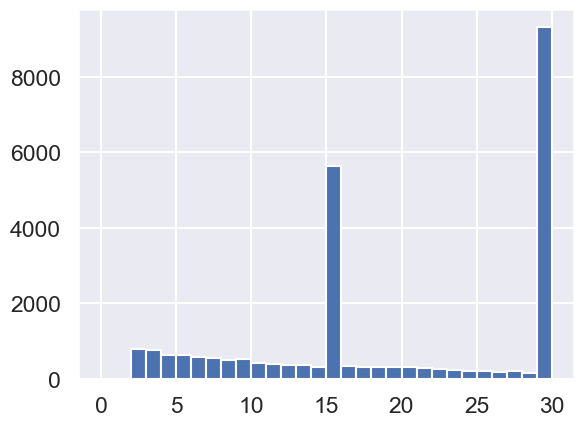

In [39]:
pattern = "2D Packing MIP with Time Limit (\d*\.?\d*) \[s\]"
df["TimeLimit"] = X["raw"].str.extract(pattern).cast(pl.Float32).to_numpy()
plt.hist(df["TimeLimit"], bins=np.arange(0,31, 1));

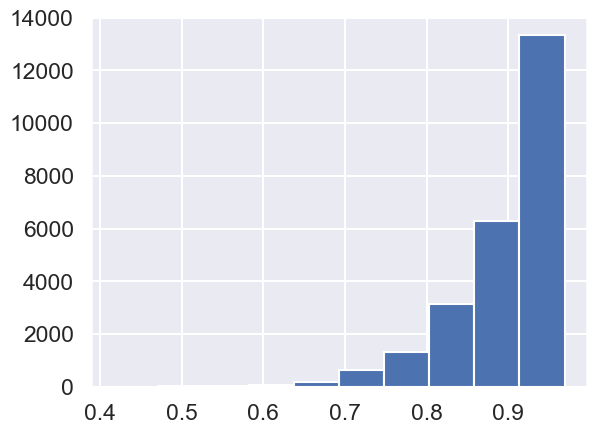

In [40]:
pattern = "- packed 2D Vol Ratio: (\d*\.?\d*) \[%\]"
df["InitialAreaRation"] = X["raw"].str.extract(pattern).cast(pl.Float32).to_numpy()
plt.hist(df["InitialAreaRation"]);

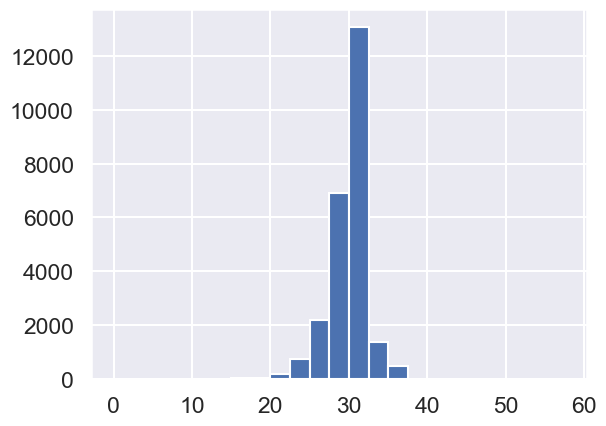

In [41]:
pattern = "MIP Improvement - 2D Vol: (\d*\.?\d*) \[m2\]"
df["InitialArea"] = X["raw"].str.extract(pattern).cast(pl.Float32).to_numpy()
plt.hist(df["InitialArea"], bins=np.arange(0, 60, 2.5));

In [42]:
df

,dataset,instance,truck_id,index,stacks,items,TotalArea,TotalWeight,ForcedLength,ForcedWidth,...,WidthRemainder_max,Length_var,Width_var,Area_var,Weight_var,LengthRemainder_var,WidthRemainder_var,TimeLimit,InitialAreaRation,InitialArea
0,C,VA,P083513403,3,27,70,0.963560,0.489860,0.888889,0.0,...,0.44,5.636793e-05,6.163524e-03,8.315348e-05,0.000003,5.923676e-03,0.016410,3.182820,0.910747,30.000000
1,X,BY6,P191069011,8,13,23,0.990893,0.459384,0.000000,0.0,...,0.04,1.688298e-04,0.000000e+00,4.083494e-05,0.000014,2.681504e-03,0.000000,15.000000,0.860293,28.338060
2,X,CI,P202412705,20,30,78,0.935087,0.932858,0.000000,0.2,...,0.44,6.618018e-04,1.262416e-02,3.602854e-04,0.000674,7.291865e-03,0.026226,15.000000,0.844687,27.823999
3,C,TA,P096382803,22,12,31,0.888889,0.272669,0.000000,0.0,...,0.84,3.724488e-04,1.104094e-02,5.846099e-04,0.000008,4.567793e-03,0.137915,8.380843,0.936768,40.000000
4,A,TR2,P206422101,38,30,93,0.910554,0.861116,0.000000,0.3,...,0.44,2.596508e-04,7.328339e-03,1.415110e-04,0.000418,1.252017e-03,0.019559,30.000000,0.947177,31.200001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,X,MA3,P173353901,24987,26,63,0.937158,0.975775,0.000000,0.0,...,0.44,1.253561e-06,0.000000e+00,2.105552e-07,0.000024,3.948034e-05,0.000000,15.000000,0.861616,28.381620
24996,C,MA2,P082210301,24990,21,55,0.961020,0.582750,0.000000,0.0,...,0.44,3.033471e-04,1.663659e-03,1.486256e-04,0.000479,8.443909e-03,0.039619,30.000000,0.936991,30.864479
24997,C,DO3,P086210203,24992,20,40,0.950305,0.502421,0.000000,0.0,...,0.14,5.255938e-09,3.620101e-07,6.945729e-10,0.000008,6.314033e-08,0.000009,15.000000,0.750499,24.721439
24998,C,MT3,P076574903,24993,26,76,0.951563,0.919613,0.000000,0.0,...,0.44,4.376068e-08,3.721084e-06,6.659436e-08,0.000095,1.535543e-06,0.000089,7.590010,0.943916,31.092600


In [43]:
y_number_improvements = X["raw"].str.extract_all("MIP Improvement").list.len()
y_improvement = (y_number_improvements > 1)
y_improvement.mean()

0.38696

In [44]:
df["improvemnt"] = y_improvement
df

,dataset,instance,truck_id,index,stacks,items,TotalArea,TotalWeight,ForcedLength,ForcedWidth,...,Length_var,Width_var,Area_var,Weight_var,LengthRemainder_var,WidthRemainder_var,TimeLimit,InitialAreaRation,InitialArea,improvemnt
0,C,VA,P083513403,3,27,70,0.963560,0.489860,0.888889,0.0,...,5.636793e-05,6.163524e-03,8.315348e-05,0.000003,5.923676e-03,0.016410,3.182820,0.910747,30.000000,False
1,X,BY6,P191069011,8,13,23,0.990893,0.459384,0.000000,0.0,...,1.688298e-04,0.000000e+00,4.083494e-05,0.000014,2.681504e-03,0.000000,15.000000,0.860293,28.338060,False
2,X,CI,P202412705,20,30,78,0.935087,0.932858,0.000000,0.2,...,6.618018e-04,1.262416e-02,3.602854e-04,0.000674,7.291865e-03,0.026226,15.000000,0.844687,27.823999,False
3,C,TA,P096382803,22,12,31,0.888889,0.272669,0.000000,0.0,...,3.724488e-04,1.104094e-02,5.846099e-04,0.000008,4.567793e-03,0.137915,8.380843,0.936768,40.000000,False
4,A,TR2,P206422101,38,30,93,0.910554,0.861116,0.000000,0.3,...,2.596508e-04,7.328339e-03,1.415110e-04,0.000418,1.252017e-03,0.019559,30.000000,0.947177,31.200001,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,X,MA3,P173353901,24987,26,63,0.937158,0.975775,0.000000,0.0,...,1.253561e-06,0.000000e+00,2.105552e-07,0.000024,3.948034e-05,0.000000,15.000000,0.861616,28.381620,False
24996,C,MA2,P082210301,24990,21,55,0.961020,0.582750,0.000000,0.0,...,3.033471e-04,1.663659e-03,1.486256e-04,0.000479,8.443909e-03,0.039619,30.000000,0.936991,30.864479,True
24997,C,DO3,P086210203,24992,20,40,0.950305,0.502421,0.000000,0.0,...,5.255938e-09,3.620101e-07,6.945729e-10,0.000008,6.314033e-08,0.000009,15.000000,0.750499,24.721439,False
24998,C,MT3,P076574903,24993,26,76,0.951563,0.919613,0.000000,0.0,...,4.376068e-08,3.721084e-06,6.659436e-08,0.000095,1.535543e-06,0.000089,7.590010,0.943916,31.092600,False


### Visualizations:

In [45]:
px.histogram(x = df["TotalArea"],
             color = df["improvemnt"],
             facet_row = df["improvemnt"],
             labels = {
               "x": "Total Stack Area",
             }
            )

In [46]:
px.histogram(x = df["TotalWeight"],
             color = df["improvemnt"],
             facet_row = df["improvemnt"],
             labels = {
               "x": "Total Stack Weight",
             }
            )

In [47]:
px.histogram(x = df["stops"],
             color = df["improvemnt"],
             facet_row = df["improvemnt"],
             labels = {
               "x": "Total Truck Stops",
             }
            )

In [48]:
px.histogram(x = df["TimeLimit"],
             color = df["improvemnt"],
             facet_row = df["improvemnt"],
             labels = {
               "x": "Time Limit",
             },
             log_y=True, #log_x=True
            )

In [49]:
px.scatter(x = df["TotalArea"],
           y = df["TotalWeight"],
           color = df["improvemnt"],
           #size = df.collect().select("stacks").to_series(),
           opacity = 0.2,
           labels = {
               "x": "Total Stack Area",
               "y": "Total Stack Weight"
           }
          )

In [50]:
px.scatter(x = df["LengthRemainder_mean"],
           y = df["WidthRemainder_mean"],
           color = df["improvemnt"],
           #size = df.collect().select("stacks").to_series(),
           opacity = 0.1,
           labels = {
               "x": "LengthRemainder Minimum",
               "y": "WidthRemainder Minimum"
           }
          )

In [51]:
px.scatter(x = df["LengthRemainder_max"],
           y = df["WidthRemainder_max"],
           color = df["improvemnt"],
           #size = df.collect().select("stacks").to_series(),
           opacity = 0.1,
           labels = {
               "x": "LengthRemainder Maximum",
               "y": "WidthRemainder Maximum"
           },
           #log_x = True, log_y = True
          )

In [52]:
px.scatter(x = df["LengthRemainder_var"]**0.5,
           y = df["WidthRemainder_var"]**0.5,
           color = df["improvemnt"],
           #size = df.collect().select("stacks").to_series(),
           opacity = 0.1,
           labels = {
               "x": "LengthRemainder Standard Deviation",
               "y": "WidthRemainder Standard Deviation"
           },
           #log_x = True, log_y = True
          )

In [53]:
px.scatter(x = df["InitialArea"],
           y = df["InitialAreaRation"],
           color = df["improvemnt"],
           #size = df.collect().select("stacks").to_series(),
           opacity = 0.1,
           labels = {
               "x": "InitialArea",
               "y": "InitialAreaRation"
           },
           log_x = True, log_y = True
          )

In [54]:
px.scatter(x = df["TotalArea"],
           y = df["InitialAreaRation"],
           color = df["improvemnt"],
           #size = df.collect().select("stacks").to_series(),
           opacity = 0.1,
           labels = {
               "x": "TotalArea",
               "y": "InitialArea"
           },
           log_x = True,
           #log_y = True
          )

### Preperation

In [55]:
X = df.iloc[:,4:-1].copy()
X

,stacks,items,TotalArea,TotalWeight,ForcedLength,ForcedWidth,stops,Length_mean,Width_mean,LengthRemainder_mean,...,WidthRemainder_max,Length_var,Width_var,Area_var,Weight_var,LengthRemainder_var,WidthRemainder_var,TimeLimit,InitialAreaRation,InitialArea
0,27,70,0.963560,0.489860,0.888889,0.0,1,0.084931,0.415908,0.178485,...,0.44,5.636793e-05,6.163524e-03,8.315348e-05,0.000003,5.923676e-03,0.016410,3.182820,0.910747,30.000000
1,13,23,0.990893,0.459384,0.000000,0.0,1,0.154986,0.491803,0.105293,...,0.04,1.688298e-04,0.000000e+00,4.083494e-05,0.000014,2.681504e-03,0.000000,15.000000,0.860293,28.338060
2,30,78,0.935087,0.932858,0.000000,0.2,5,0.081723,0.347678,0.063581,...,0.44,6.618018e-04,1.262416e-02,3.602854e-04,0.000674,7.291865e-03,0.026226,15.000000,0.844687,27.823999
3,12,31,0.888889,0.272669,0.000000,0.0,1,0.128395,0.562842,0.141969,...,0.84,3.724488e-04,1.104094e-02,5.846099e-04,0.000008,4.567793e-03,0.137915,8.380843,0.936768,40.000000
4,30,93,0.910554,0.861116,0.000000,0.3,6,0.080602,0.360246,0.019600,...,0.44,2.596508e-04,7.328339e-03,1.415110e-04,0.000418,1.252017e-03,0.019559,30.000000,0.947177,31.200001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,26,63,0.937158,0.975775,0.000000,0.0,2,0.087949,0.409836,0.013952,...,0.44,1.253561e-06,0.000000e+00,2.105552e-07,0.000024,3.948034e-05,0.000000,15.000000,0.861616,28.381620
24996,21,55,0.961020,0.582750,0.000000,0.0,2,0.102222,0.441062,0.079023,...,0.44,3.033471e-04,1.663659e-03,1.486256e-04,0.000479,8.443909e-03,0.039619,30.000000,0.936991,30.864479
24997,20,40,0.950305,0.502421,0.000000,0.0,1,0.100644,0.472111,0.230511,...,0.14,5.255938e-09,3.620101e-07,6.945729e-10,0.000008,6.314033e-08,0.000009,15.000000,0.750499,24.721439
24998,26,76,0.951563,0.919613,0.000000,0.0,3,0.089026,0.411097,0.007865,...,0.44,4.376068e-08,3.721084e-06,6.659436e-08,0.000095,1.535543e-06,0.000089,7.590010,0.943916,31.092600


In [56]:
#y = y.numpy()
#y = y[:,0]
y = y_improvement
round(1-y.mean(), 3)

0.613

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/5, stratify = y, random_state = 3093453)

# ML model:

In [58]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, Normalizer
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, uniform, binom, poisson
from sklearn.metrics import classification_report

import warnings
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, uniform, poisson, geom

# Model Competition:

### Lasso Logistic Regression

In [59]:
sgd_pipe = make_pipeline(
    StandardScaler(),
    #PCA(0.99),
    Normalizer(),
    #PolynomialFeatures(include_bias = False, interaction_only = True),
    #LogisticRegression(solver = "saga", max_iter = 10_000)
    SGDClassifier(penalty="l1", max_iter = 100_000, early_stopping = True, warm_start=True)
)

sgd_param_dist = {
    "normalizer__norm": ["l1", "l2"],
    "sgdclassifier__alpha": expon(0.0001),
    "sgdclassifier__eta0": expon(12),
    "sgdclassifier__power_t": expon(5),
}

### Decision Tree

In [60]:
dt_pipe = make_pipeline(
    StandardScaler(),
    #PCA(0.99),
    Normalizer(),
    #PolynomialFeatures(include_bias = False, interaction_only = True),
    #LogisticRegression(solver = "saga", max_iter = 10_000)
    DecisionTreeClassifier()
)

dt_param_dist = {
    "normalizer__norm": ["l1", "l2"],
    "decisiontreeclassifier__criterion": ["gini", "entropy"],
    "decisiontreeclassifier__splitter": ["best", "random"],
    "decisiontreeclassifier__max_depth": poisson(7, loc = 1),
    "decisiontreeclassifier__min_samples_split": poisson(6, loc = 2),
    "decisiontreeclassifier__min_samples_leaf": poisson(6, loc = 1),
    "decisiontreeclassifier__max_features": ["sqrt", "log2"]
}

### RandomForest

In [61]:
rfc_pipe = make_pipeline(
    StandardScaler(),
    #PCA(0.99),
    Normalizer(),
    RandomForestClassifier(n_estimators = 50)
)

rfc_param_dist = {
    "normalizer__norm": ["l1", "l2"],
    "randomforestclassifier__n_estimators": poisson(50, loc = 10),
    "randomforestclassifier__criterion": ["gini", "entropy"],
    "randomforestclassifier__max_depth": poisson(7, loc = 1),
    "randomforestclassifier__min_samples_split": poisson(6, loc = 2),
    "randomforestclassifier__min_samples_leaf": poisson(6, loc = 1),
    "randomforestclassifier__max_features": ["sqrt", "log2"]
}

### KNN

In [62]:
knn_pipe = make_pipeline(
    StandardScaler(),
    Normalizer(),
    KNeighborsClassifier()
)

knn_param_dist = {
    "normalizer__norm": ["l1", "l2"],
    "kneighborsclassifier__n_neighbors": poisson(7),
    "kneighborsclassifier__weights": ["uniform", "distance"],
    "kneighborsclassifier__p": poisson(1, loc=1),
}

### GNB

In [63]:
gnb_pipe = make_pipeline(
    StandardScaler(),
    Normalizer(),
    GaussianNB()
)

gnb_param_dist = {
    "normalizer__norm": ["l1", "l2"],
}

## Competition

In [64]:
clfs = [
    "Lasso Logistic Regression",
    #"Decision Tree Classifier",
    "Random Forest Classifier",
    "K Nearest Neighbor",
    "Gaussian Naive Bayes",
]

pipes = {
    "Lasso Logistic Regression": sgd_pipe,
    "Decision Tree Classifier": dt_pipe,
    "Random Forest Classifier": rfc_pipe,
    "K Nearest Neighbor": knn_pipe,
    "Gaussian Naive Bayes": gnb_pipe,
}

param_dists = {
    "Lasso Logistic Regression": sgd_param_dist,
    "Decision Tree Classifier": dt_param_dist,
    "Random Forest Classifier": rfc_param_dist,
    "K Nearest Neighbor": knn_param_dist,
    "Gaussian Naive Bayes": gnb_param_dist,
}

training_times = {}
testing_times = {}

best_estimators = {}
acc_scores = {}
f1_scores = {}
auc_scores = {}

In [65]:
from time import time
from sklearn import metrics
from copy import copy
from sklearn.model_selection import StratifiedKFold

n_cv = 10
cv = StratifiedKFold(n_cv, random_state=3093453, shuffle=True)

for i, clf in enumerate(clfs):
    print("####", clf, "####")
    pipe = pipes[clf]
    param_dist = param_dists[clf]


    training_times[clf] = []
    testing_times[clf]  = []

    acc_scores[clf] = []
    f1_scores[clf]  = []
    auc_scores[clf] = []

    
    rscv = RandomizedSearchCV(
        pipe, param_dist, n_iter = 24, cv = 5,
        scoring = "average_precision",
        n_jobs = 8
    )

    rscv.fit(X_train, y_train)
    
    rscv.best_estimator_.fit(X_train, y_train)

    rscv.best_estimator_.predict(X_train)

    best_estimators[clf] = copy(rscv.best_estimator_)

    
    #y_pred = rscv.best_estimator_.predict(X_train)
    #print("training scores:")
    #print("-"* 53)
    #print(classification_report(y_train, y_pred, digits = 3))
    
    print("testing scores:")
    print("-"* 53)
    y_pred = rscv.best_estimator_.predict(X_test)
    print(classification_report(y_test, y_pred, digits = 3)) 

    
    # generate training times:

    for train_idx, test_idx in cv.split(X, y):
        t0 = time()
        rscv.best_estimator_.fit(X.iloc[train_idx], y[train_idx])
        t1 = time()
        t = t1 - t0
        training_times[clf].append(t)

        t0 = time()
        rscv.best_estimator_.predict(X.iloc[train_idx])
        t1 = time()
        t = t1 - t0
        testing_times[clf].append(t)


        y_pred = rscv.best_estimator_.predict(X.iloc[test_idx])
        
        acc_scores[clf].append(metrics.accuracy_score(y[test_idx], y_pred))
        f1_scores[clf].append(metrics.f1_score(y[test_idx], y_pred))
        auc_scores[clf].append(metrics.average_precision_score(y[test_idx], y_pred))
    

#### Lasso Logistic Regression ####
testing scores:
-----------------------------------------------------
              precision    recall  f1-score   support

       False      0.675     0.879     0.763      3065
        True      0.631     0.328     0.432      1935

    accuracy                          0.666      5000
   macro avg      0.653     0.604     0.598      5000
weighted avg      0.658     0.666     0.635      5000

#### Random Forest Classifier ####
testing scores:
-----------------------------------------------------
              precision    recall  f1-score   support

       False      0.692     0.817     0.749      3065
        True      0.594     0.425     0.495      1935

    accuracy                          0.665      5000
   macro avg      0.643     0.621     0.622      5000
weighted avg      0.654     0.665     0.651      5000

#### K Nearest Neighbor ####
testing scores:
-----------------------------------------------------
              precision    recall  f

/Users/fynn/Uni/MA/.venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning:

The total space of parameters 2 is smaller than n_iter=24. Running 2 iterations. For exhaustive searches, use GridSearchCV.



testing scores:
-----------------------------------------------------
              precision    recall  f1-score   support

       False      0.690     0.821     0.750      3065
        True      0.594     0.415     0.489      1935

    accuracy                          0.664      5000
   macro avg      0.642     0.618     0.619      5000
weighted avg      0.653     0.664     0.649      5000



### Times

In [66]:
train_times = pd.DataFrame(training_times)
test_times = pd.DataFrame(testing_times)
train_times["Job"] = f"Training: {len(train_idx):>5} samples"
test_times["Job"] =  f"Testing : {len(test_idx):>5}   samples"

times = pd.concat([train_times, test_times])
times = times.melt("Job")
times.head(10)

,Job,variable,value
0,Training: 22500 samples,Lasso Logistic Regression,0.035957
1,Training: 22500 samples,Lasso Logistic Regression,0.033902
2,Training: 22500 samples,Lasso Logistic Regression,0.045235
3,Training: 22500 samples,Lasso Logistic Regression,0.037833
4,Training: 22500 samples,Lasso Logistic Regression,0.062910
5,Training: 22500 samples,Lasso Logistic Regression,0.040030
6,Training: 22500 samples,Lasso Logistic Regression,0.033826
7,Training: 22500 samples,Lasso Logistic Regression,0.033763
8,Training: 22500 samples,Lasso Logistic Regression,0.031097
9,Training: 22500 samples,Lasso Logistic Regression,0.034010


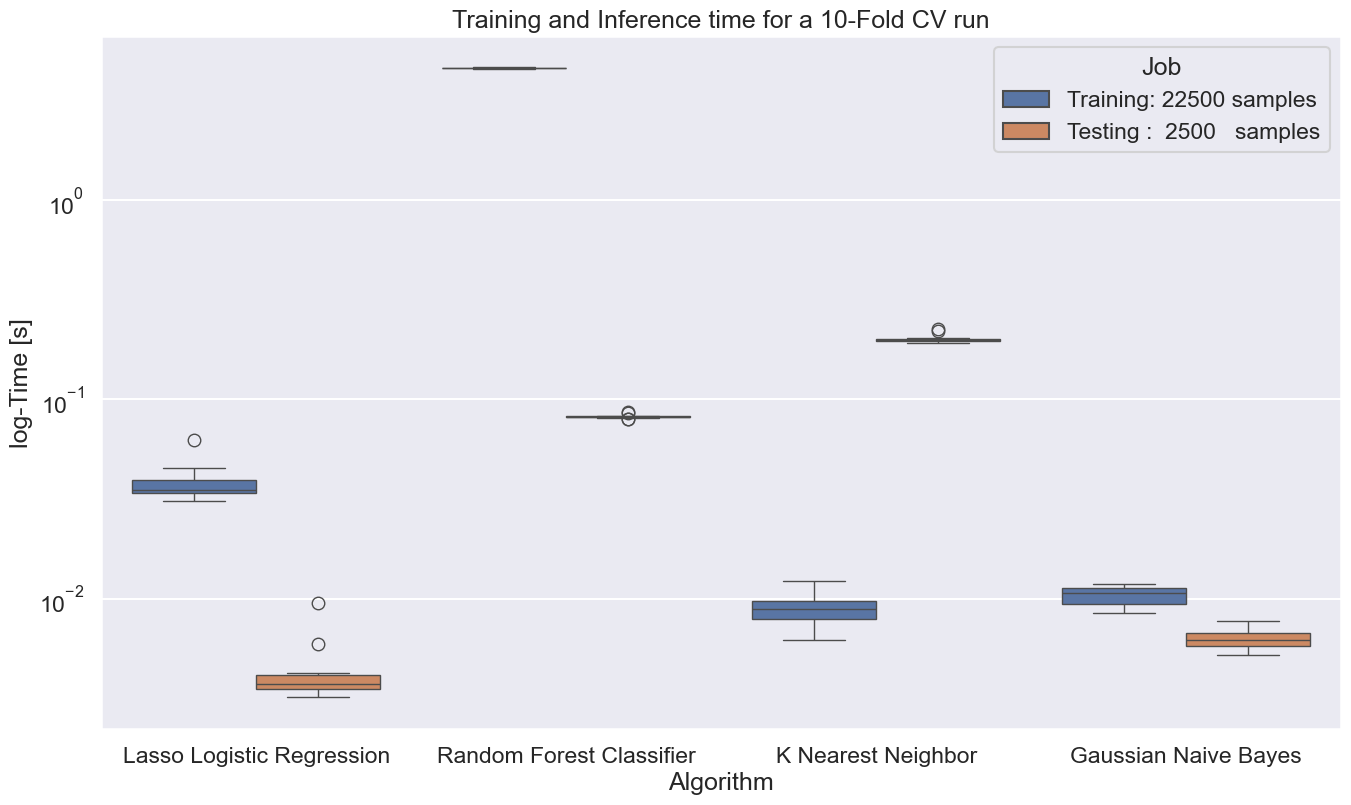

In [67]:
plt.figure(figsize=(16, 9))
sns.boxplot(data=times, x="variable", y="value", hue="Job");

plt.xlabel("Algorithm")
plt.xticks(rotation=10);

plt.ylabel("log-Time [s]")
plt.yscale("log");

plt.title(f"Training and Inference Time of ML Algorithms for a {n_cv}-Fold CV run");


path = os.path.join(cwd, "plots", "2023-10-31-ML-Competition", "Time_by_Algorithm_no_DNN.png")
plt.savefig(path)

### Accuracy

In [68]:
acc = pd.DataFrame(acc_scores)
f1 = pd.DataFrame(f1_scores)
auc = pd.DataFrame(auc_scores)
acc["Metric"] = "Accuracy"
f1["Metric"] = "F1 score"
auc["Metric"] = "Average Precision"

scores = pd.concat([acc, f1, auc])
scores = scores.melt("Metric")
scores.head(10)

,Metric,variable,value
0,Accuracy,Lasso Logistic Regression,0.6408
1,Accuracy,Lasso Logistic Regression,0.6596
2,Accuracy,Lasso Logistic Regression,0.6660
3,Accuracy,Lasso Logistic Regression,0.6536
4,Accuracy,Lasso Logistic Regression,0.6556
5,Accuracy,Lasso Logistic Regression,0.6592
6,Accuracy,Lasso Logistic Regression,0.6764
7,Accuracy,Lasso Logistic Regression,0.6620
8,Accuracy,Lasso Logistic Regression,0.6676
9,Accuracy,Lasso Logistic Regression,0.6688


In [ ]:
plt.figure(figsize=(16, 9))
sns.barplot(data=scores, x="variable", y="value", hue="Metric",
           errorbar="sd"
           );

plt.xlabel("Algorithm");
plt.xticks(rotation=10);


plt.ylim([-0.001, .8])
plt.axhline(1-y.mean(), c="k", label=f"Prevalence: {1-y.mean():.1%}")
plt.yticks(np.arange(0, 90, 10)/100, [str(i)+"%" for i in np.arange(0, 90, 10)])
plt.ylabel("Score")

plt.title(f"Improvement Prediction Performance of ML Algorithms for a {n_cv}-Fold CV run");
plt.legend(loc="lower right")

path = os.path.join(cwd, "plots", "2023-10-31-ML-Competition", "Metrics_by_Algorithm_no_DNN.png")
plt.savefig(path)

## Inference:

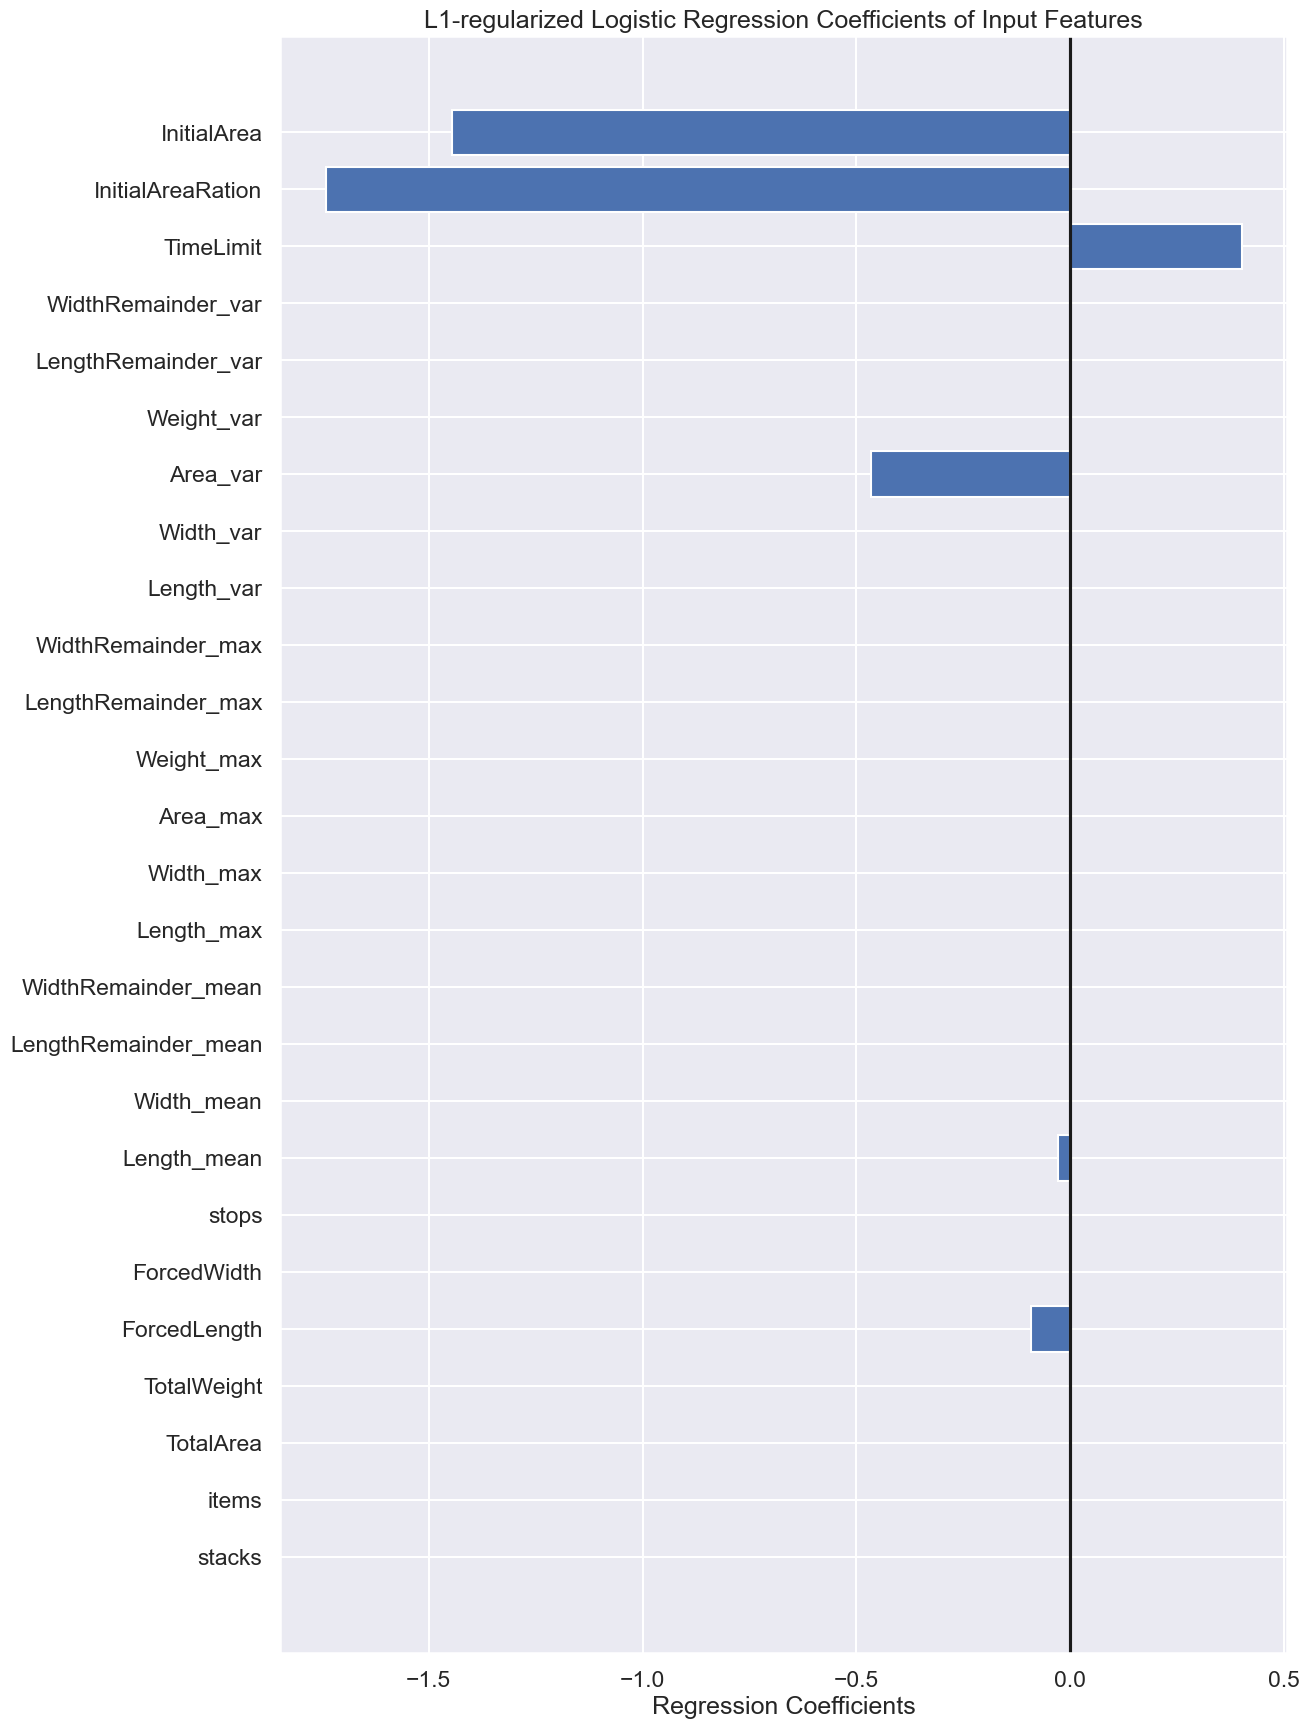

In [70]:
clf = best_estimators["Lasso Logistic Regression"][-1]
plt.figure(figsize = (13, 21))
plt.barh(best_estimators["Lasso Logistic Regression"][:-1].get_feature_names_out(), clf.coef_[0]);


plt.axvline(0, c="k");
plt.title("L1-regularized Logistic Regression Coefficients of Input Features");
plt.xlabel("Regression Coefficients");

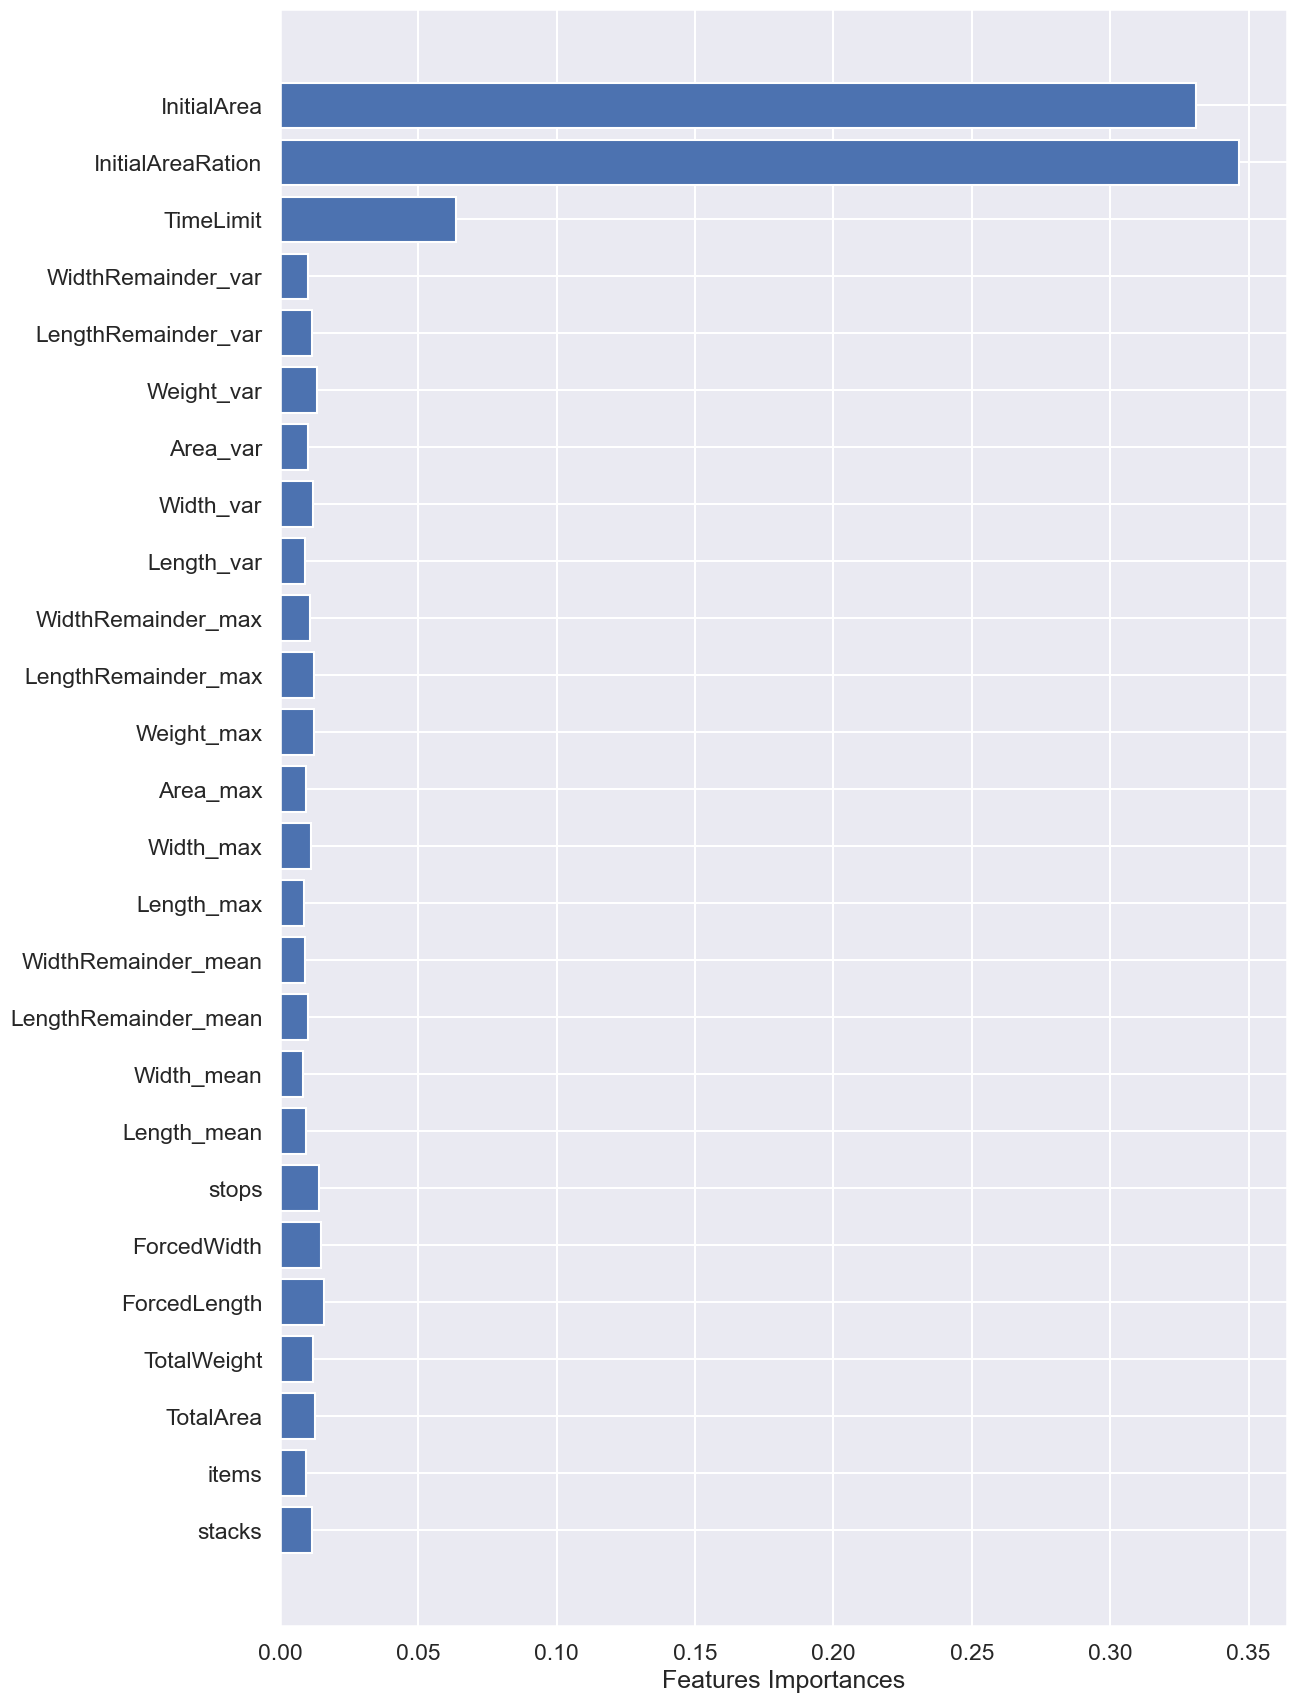

In [71]:
clf = best_estimators["Random Forest Classifier"]["randomforestclassifier"]
plt.figure(figsize = (13, 21))

clms = X.columns

plt.barh(clms, clf.feature_importances_);
plt.xlabel("Features Importances");

## Build A Deep Learning model

In [72]:
activation="gelu"
units=10


model = keras.Sequential([
    keras.layers.Input(X.shape[1]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(activation=activation, units=units),
    keras.layers.Dense(activation=activation, units=units),
    keras.layers.Dense(activation=activation, units=units),
    keras.layers.Dense(activation="sigmoid", units=1)
])

model.compile(
    loss="binary_crossentropy",
    metrics="accuracy",
)

In [74]:
callbacks=[
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
    #keras.callbacks.ModelCheckpoint()
]

history = model.fit(
    X.to_numpy(), y.to_numpy(),
    #batch_size=
    epochs=100,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
704/704 [==============================] - 7s 9ms/step - loss: 0.6043 - accuracy: 0.6698 - val_loss: 0.6233 - val_accuracy: 0.6364
Epoch 2/100
704/704 [==============================] - 7s 10ms/step - loss: 0.6036 - accuracy: 0.6707 - val_loss: 0.6246 - val_accuracy: 0.6400
Epoch 3/100
704/704 [==============================] - 7s 10ms/step - loss: 0.6027 - accuracy: 0.6692 - val_loss: 0.6230 - val_accuracy: 0.6392
Epoch 4/100
704/704 [==============================] - 6s 9ms/step - loss: 0.6039 - accuracy: 0.6694 - val_loss: 0.6225 - val_accuracy: 0.6384
Epoch 5/100
704/704 [==============================] - 6s 9ms/step - loss: 0.6034 - accuracy: 0.6690 - val_loss: 0.6222 - val_accuracy: 0.6428
Epoch 6/100
704/704 [==============================] - 7s 9ms/step - loss: 0.6030 - accuracy: 0.6693 - val_loss: 0.6226 - val_accuracy: 0.6460
Epoch 7/100
704/704 [==============================] - 7s 9ms/step - loss: 0.6013 - accuracy: 0.6691 - val_loss: 0.6234 - val_accuracy: 0.64

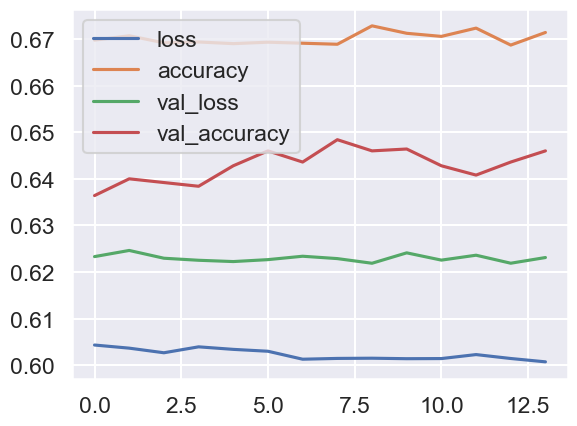

In [75]:
pd.DataFrame(history.history).plot();

In [77]:
clf = "Neural Network"

training_times[clf] = []
testing_times[clf]  = []

acc_scores[clf] = []
f1_scores[clf]  = []
auc_scores[clf] = []

for train_idx, test_idx in cv.split(X, y):
    model = keras.Sequential([
        keras.layers.Input(X.shape[1]),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(activation=activation, units=units),
        keras.layers.Dense(activation=activation, units=units),
        keras.layers.Dense(activation=activation, units=units),
        keras.layers.Dense(activation="sigmoid", units=1)
    ])
    
    model.compile(
        loss="binary_crossentropy",
        metrics="accuracy",
    )
    
    t0 = time()
    history = model.fit(
        X.to_numpy()[train_idx], y.to_numpy()[train_idx],
        #batch_size=
        epochs=100,
        validation_split=0.1,
        callbacks=callbacks,
        verbose=0
    )
    t1 = time()
    t = t1 - t0
    training_times[clf].append(t)

    t0 = time()
    model(X.to_numpy()[train_idx])
    t1 = time()
    t = t1 - t0
    testing_times[clf].append(t)


    y_pred = model.predict(X.to_numpy()[test_idx]).round()
        
    acc_scores[clf].append(metrics.accuracy_score(y[test_idx], y_pred))
    f1_scores[clf].append(metrics.f1_score(y[test_idx], y_pred))
    auc_scores[clf].append(metrics.average_precision_score(y[test_idx], y_pred))
    

79/79 [==============================] - 0s 3ms/step


In [78]:
train_times = pd.DataFrame(training_times)
test_times = pd.DataFrame(testing_times)
train_times["Job"] = f"Training: {len(train_idx):>5} samples"
test_times["Job"] =  f"Testing : {len(test_idx):>5}   samples"

times = pd.concat([train_times, test_times])
times = times.melt("Job")
times.head(10)

,Job,variable,value
0,Training: 22500 samples,Lasso Logistic Regression,0.035957
1,Training: 22500 samples,Lasso Logistic Regression,0.033902
2,Training: 22500 samples,Lasso Logistic Regression,0.045235
3,Training: 22500 samples,Lasso Logistic Regression,0.037833
4,Training: 22500 samples,Lasso Logistic Regression,0.062910
5,Training: 22500 samples,Lasso Logistic Regression,0.040030
6,Training: 22500 samples,Lasso Logistic Regression,0.033826
7,Training: 22500 samples,Lasso Logistic Regression,0.033763
8,Training: 22500 samples,Lasso Logistic Regression,0.031097
9,Training: 22500 samples,Lasso Logistic Regression,0.034010


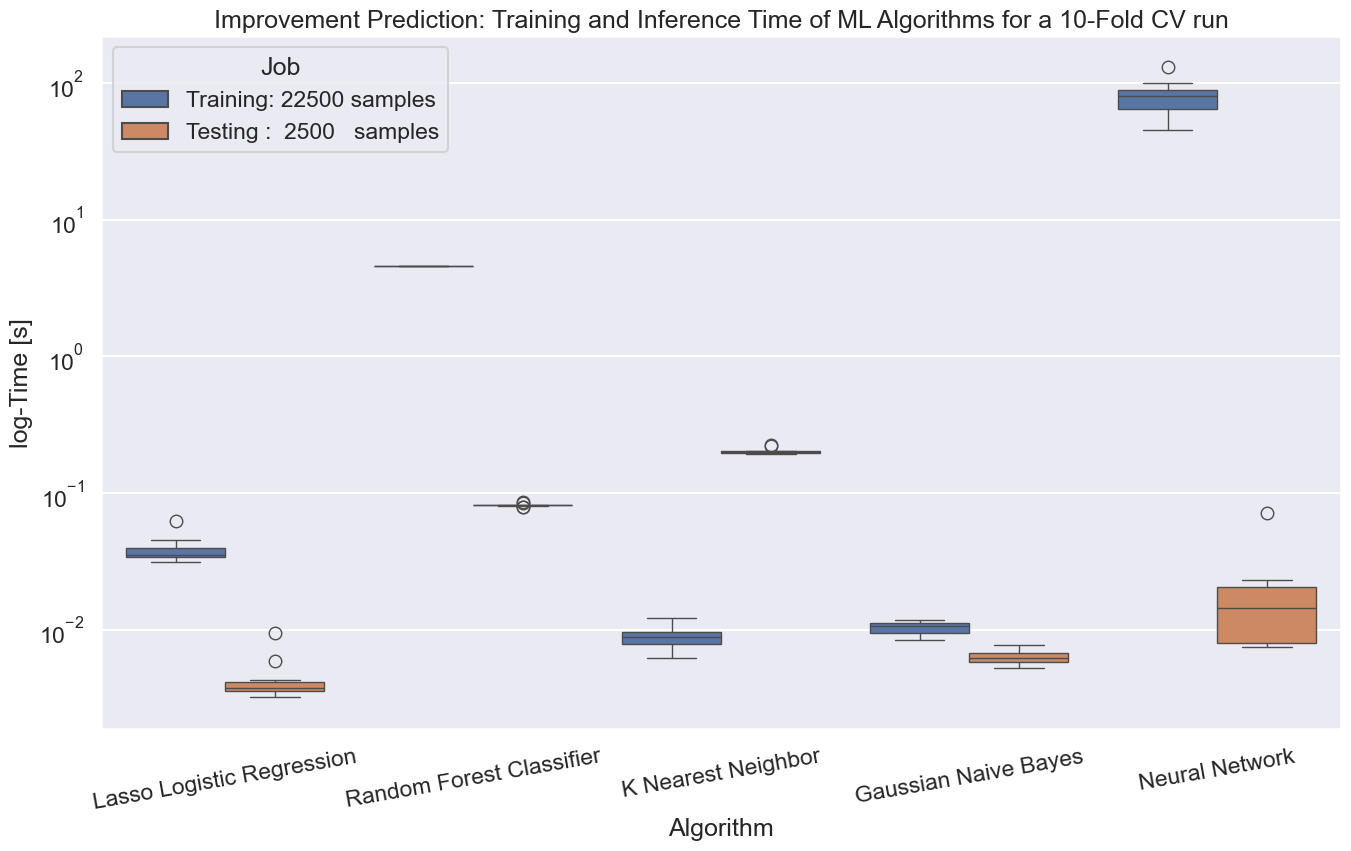

In [101]:
plt.figure(figsize=(16, 9))
sns.boxplot(data=times, x="variable", y="value", hue="Job");

plt.xlabel("Algorithm")
plt.xticks(rotation=10);

plt.ylabel("log-Time [s]")
plt.yscale("log");

plt.title(f"Improvement Prediction: Training and Inference Time of ML Algorithms for a {n_cv}-Fold CV run");


path = os.path.join(cwd, "plots", "2023-10-31-ML-Competition", "Time_by_Algorithm.png")
plt.savefig(path)

In [80]:
acc = pd.DataFrame(acc_scores)
f1 = pd.DataFrame(f1_scores)
auc = pd.DataFrame(auc_scores)
acc["Metric"] = "Accuracy"
f1["Metric"] = "F1 score"
auc["Metric"] = "Average Precision"

scores = pd.concat([acc, f1, auc])
scores = scores.melt("Metric")
scores.head(10)

,Metric,variable,value
0,Accuracy,Lasso Logistic Regression,0.6408
1,Accuracy,Lasso Logistic Regression,0.6596
2,Accuracy,Lasso Logistic Regression,0.6660
3,Accuracy,Lasso Logistic Regression,0.6536
4,Accuracy,Lasso Logistic Regression,0.6556
5,Accuracy,Lasso Logistic Regression,0.6592
6,Accuracy,Lasso Logistic Regression,0.6764
7,Accuracy,Lasso Logistic Regression,0.6620
8,Accuracy,Lasso Logistic Regression,0.6676
9,Accuracy,Lasso Logistic Regression,0.6688


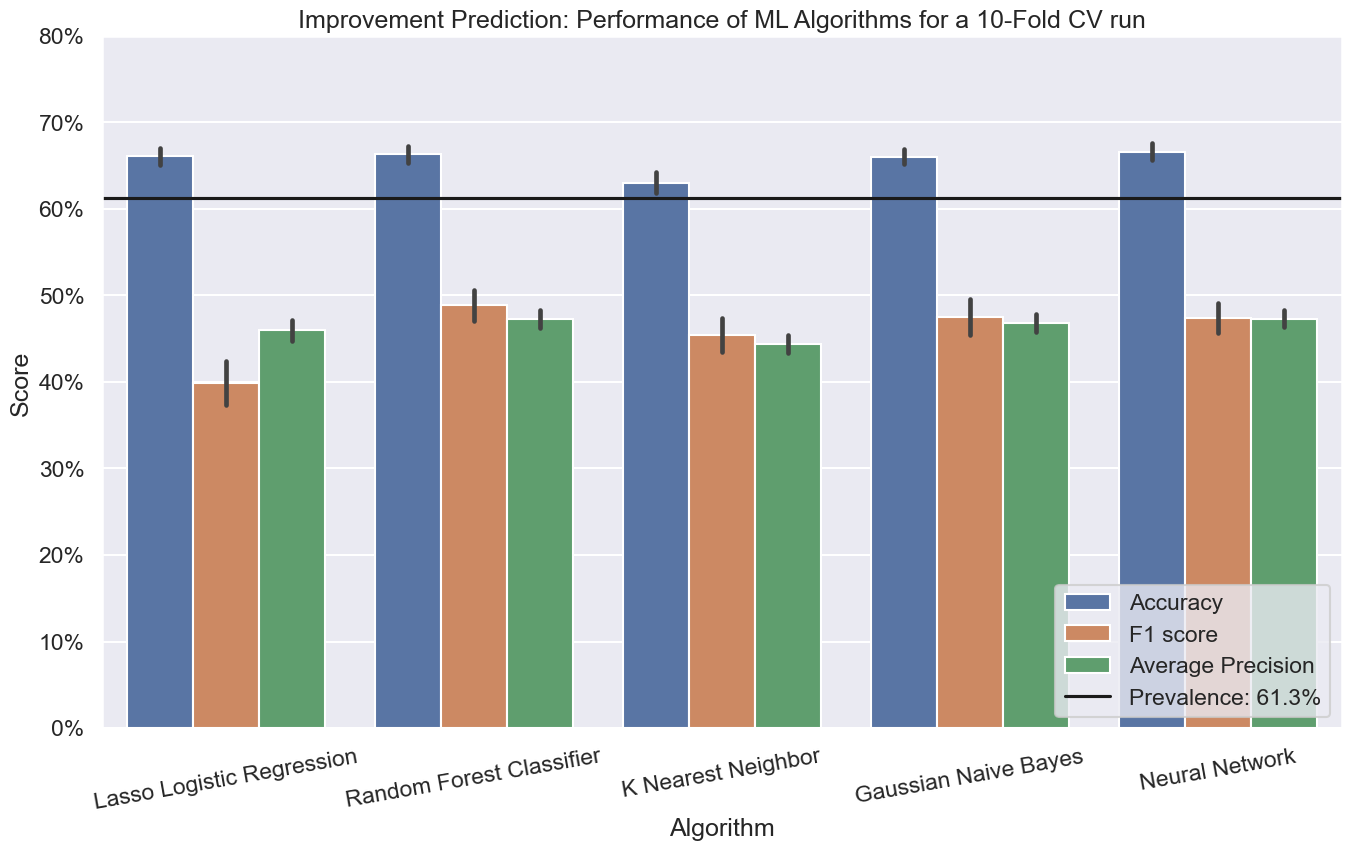

In [100]:
plt.figure(figsize=(16, 9))
sns.barplot(data=scores, x="variable", y="value", hue="Metric",
           errorbar="sd"
           );

plt.xlabel("Algorithm");
plt.xticks(rotation=10);


plt.ylim([-0.001, .8])
plt.axhline(1-y.mean(), c="k", label=f"Prevalence: {1-y.mean():.1%}")
plt.yticks(np.arange(0, 90, 10)/100, [str(i)+"%" for i in np.arange(0, 90, 10)])
plt.ylabel("Score")

plt.title(f"Improvement Prediction: Performance of ML Algorithms for a {n_cv}-Fold CV run");
plt.legend(loc="lower right")

path = os.path.join(cwd, "plots", "2023-10-31-ML-Competition", "Metrics_by_Algorithm.png")
plt.savefig(path)